# Procesamiento de Lenguaje Natural - **Representaciones basadas en Deep Learning**

Esta notebook presenta ejemplos de los diferentes aspectos relacionados con las formas de representación de texto basadas en Deep Learning vistas en clase.

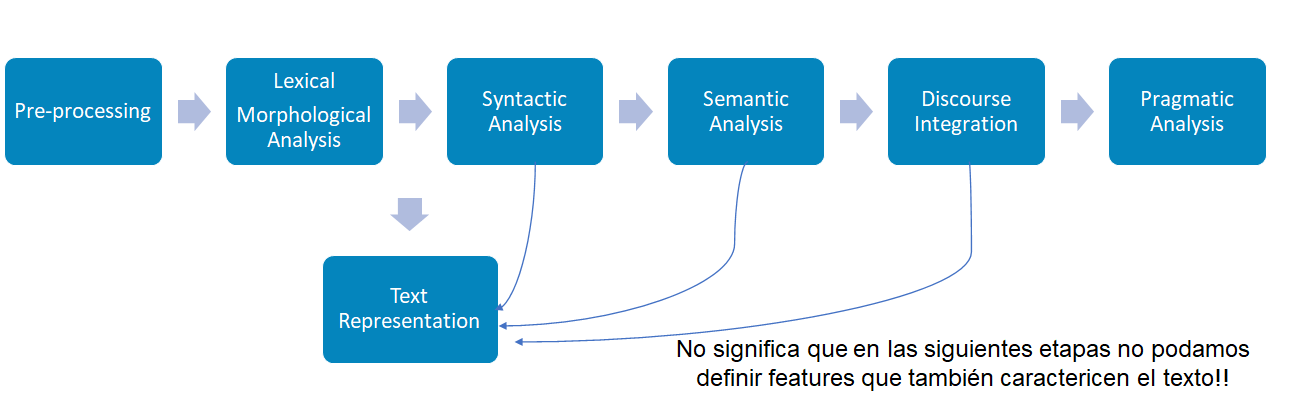

Si bien las técnicas anteriores son efectivas para la extracción de características, pierden información como: 
* Semántica.
* Estructura.
* Contexto y secuencia.

Las representaciones tradicionales requieren gran cantidad de datos.  Sin datos, los modelos pueden no capturar lo esencial/relevante. Esto puede llevar a problemáticas como *"curse of dimensionality"* (si bien la cantidad de features aumenta exponencialmente, los textos solo presentan una pequeña fracción de las palabras en el diccionario) y también a *overfitting*.

Las representaciones basadas en Deep Learning se basan en inferencia de semántica, asumiendo que palabras que ocurren y son utilizadas en el mismo contexto son semánticamente y contextualmente similares. En este contexto: “una palabra se caracteriza por la compañía que tiene”.

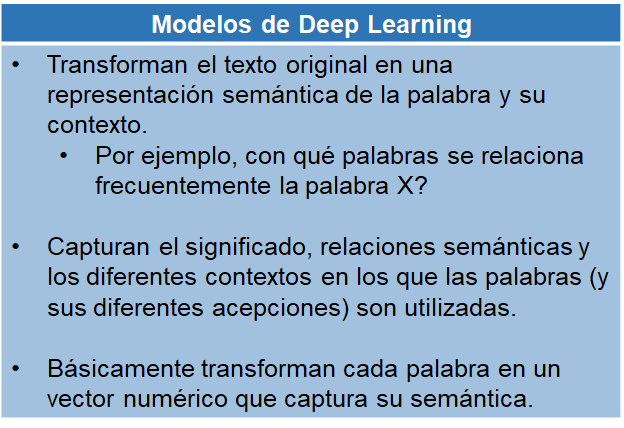

Un pequeño resumen de lo que fue apareciendo en los últimos años.

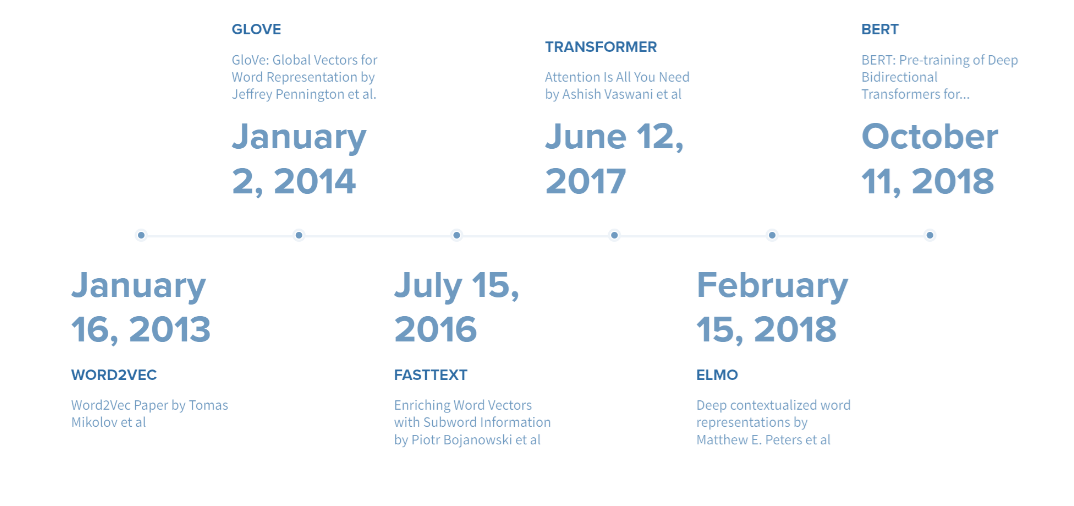

Para estas representaciones vamos a usar un corpus más grande. Particularmente, vamos a trabajar con el primer libro de Harry Potter: "Harry Potter and the Philosopher's Stone".

In [ ]:
from tqdm.notebook import tqdm
import io
import os
import requests 
import sys

def descargar_archivo(url,datapath): # como vamos a bajar varios archivos, armamos un método
  if os.path.exists(datapath): # antes de descargar el archivo controlamos que no exista
    print('File already exists')
    return 
    
  print("File does not exist")
    
  req = requests.get(url, stream=True)
  file_size = int(req.headers['Content-Length'])
  chunk_size = 1024  # 1 MB
  num_bars = int(file_size / chunk_size)

  with open(datapath, 'wb') as fp:
    for chunk in tqdm(req.iter_content(chunk_size=chunk_size), total=num_bars, unit='KB', desc=datapath, leave=True, file=sys.stdout):
      fp.write(chunk)

In [ ]:
url = "https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%201%20-%20Sorcerer's%20Stone.txt"
datapath = "harry_potter1.txt"

descargar_archivo(url,datapath)

In [ ]:
import os
import nltk
nltk.download('punkt')

In [ ]:
from nltk import sent_tokenize

with io.open(datapath, encoding='ascii', errors='ignore') as file:
  hp = file.read().strip()
   
hp = [x for x in sent_tokenize(hp)]

print(len(hp))
print(hp[20])

Nos traemos método de pre-procesamiento básico que habíamos definido.

In [ ]:
import nltk
nltk.download('stopwords')
from sklearn.base import BaseEstimator, TransformerMixin

from nltk import wordpunct_tokenize
import re

class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = nltk.corpus.stopwords.words('english')
       

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):

        return [
            ' '.join(self.tokenize(sent)) for sent in X
        ]

    def tokenize(self, sent):
        # el documento en oraciones
        sent = re.sub(r'[^a-zA-Z\s]', '', sent, re.I|re.A)
        new_sent = []
        for token in wordpunct_tokenize(sent):
           # aplicamos pre-procesamiento al token
           token = token.lower() 
           token = token.strip()
                
           # ignoramos el token si es un stopword
           if token in self.stopwords:
               continue
           new_sent.append(token)
        return new_sent

Y nos traemos el corpus pequeño para hacer algunos ejemplos.

In [ ]:
corpus = ['The sky is blue and beautiful.',
'Love this blue and beautiful sky!',
'The quick brown fox jumps over the lazy dog.',
"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
'I love green eggs, ham, sausages and bacon!',
'The brown fox is quick and the blue dog is lazy!',
'The sky is very blue and the sky is very beautiful today',
'The dog is lazy but the brown fox is quick!'
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals',
'weather', 'animals']

corpus_small = ['sky beautiful love blue sky.',
'love beautiful day',
'sky very beautiful today.'
]

labels_small = ['weather', 'weather', 'animals']

processed_corpus = NLTKPreprocessor().transform(corpus)

In [ ]:
processed_hp = NLTKPreprocessor().transform(hp)
print(processed_hp)

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_hp = [wpt.tokenize(document) for document in processed_hp]
print(tokenized_hp)

**De qué hablamos cuando hablamos de embeddings?**

* Representaciones densas de elementos en la forma de vectores en un espacio de dimensionalidad reducida

**Word embeddings** es el nombre por defecto que se le da a estas representaciones, aunque también se las puede encontrar como:
* Distributional semantic model.
* Distributed representation.
* Semantic vector space.
* Word space.


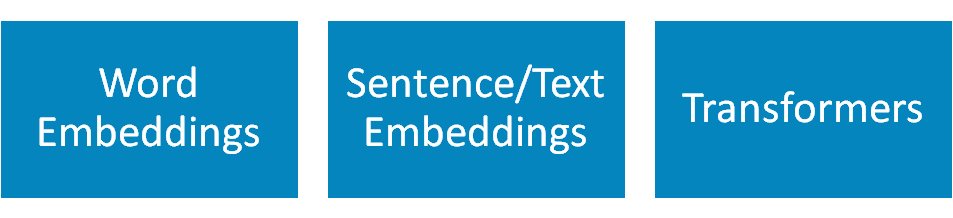

## Word Embeddings

### Word2Vec

Desarrollado por Google en 2013. Se trata de modelos supervisados que toman grandes cantidades de textos, crean un vocabulario de posibles palabras y generan representaciones densas para cada palabra.

Se puede especificar el tamaño de la representación. Es decir, cuantas features van a representar cada una de las palabras de los textos. Reduce la dimensionalidad respecto a las representaciones de bag-of-words.

A diferencia de otra representación que veremos más adelante, considera las palabras como una unidad ignorando su morfología. Esto puede resultar una limitación cuando los idiomas tienen vocabularios muy extensos con muchas palabras poco frecuentes.

Dos arquitecturas:

* CBOW trata de predecir la palabra central basado en el contexto.
* Skip Gram trata de predecir el contexto de una determinada palabra central.




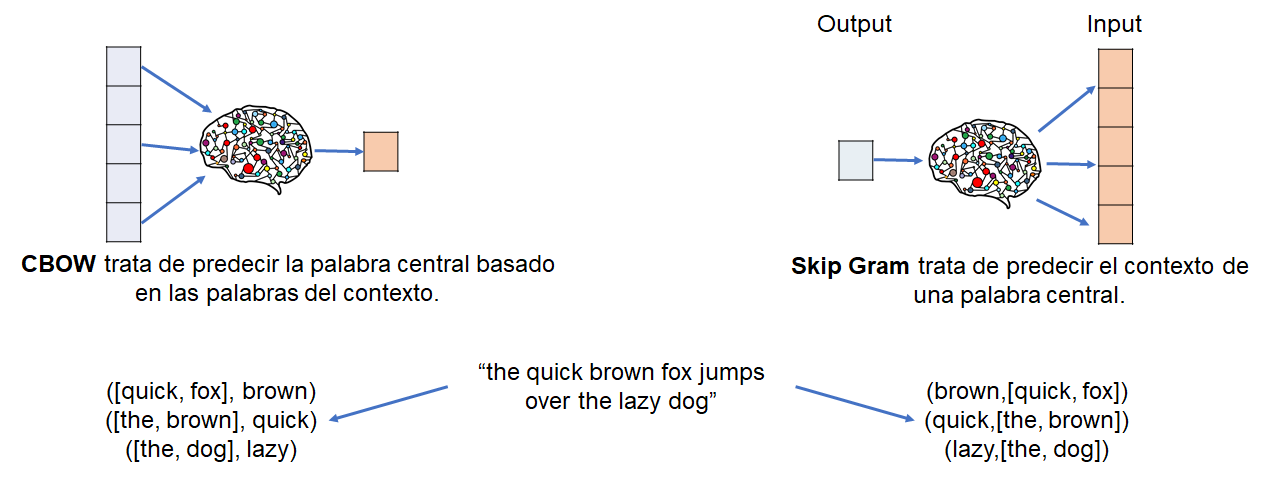

#### spaCy


Soporta también la [carga](https://spacy.io/usage/vectors-similarity#custom) de modelos custom creados con otras bibliotecas, por ejemplo, ```Gensim```.

In [ ]:
pip install spacy # en caso de que haga falta

In [ ]:
!python -m spacy download en_core_web_lg
# este modelo incluye los word vectors. 
#Hay otro modelo más liviano, "en_core_web_md" que viene con tensores de contexto que permiten calcular similarities, pero no encontrar las representaciones.

*Nota*. Esto podría fallar de acuerdo a la versión de ``spacy`` que se tenga.

In [ ]:
import spacy 
import en_core_web_lg 

nlp = en_core_web_lg.load()

Ahora, vamos a procesar una oración utilizando el modelo

In [ ]:
doc = nlp(corpus[0])

for t in doc:
  print(t.text,t.vector)

Algo que puede suceder es que la palabra para la cual se quiere obtener la representación no exista en los word vectors. En ese caso, no vamos a obtener una representación para la misma, obteniendo cero en todas las posiciones del vector.

In [ ]:
print(nlp("deployar").vector) # qué pasa si ponemos una palabra en español que no se encuentra en lo entrenado en inglés

##### Gensim

Provee una representación eficiente y escalable del modelo Word2Vec. 

Primero, vamos a utilizar los modelos pre-entrenados sobre el dataset de [Google News](https://code.google.com/archive/p/word2vec/). Este dataset contiene embeddings de dimensión 300 para 3 millones de palabras y frases.

*Nota*. Puede tardar

In [ ]:
import urllib
import os
import gzip
import shutil

url = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
datapath = "data/GoogleGoogleNews-vectors-negative300.bin"

os.makedirs("data", exist_ok=True)

In [ ]:
descargar_archivo(url,datapath+".gz")

In [ ]:
import gzip
import shutil

with gzip.open(datapath+".gz","rb") as f_in:
  with open(datapath,"wb") as f_o:
    shutil.copyfileobj(f_in,f_o)

*Nota*. Probablemente se rompa por falta de memoria. No queda otra que darle play de nuevo y seguir. (Volviendo a cargar lo que sea necesario)

In [ ]:
from gensim.models import KeyedVectors

# cargamos el modelo de Google
model = KeyedVectors.load_word2vec_format('data/GoogleGoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
# para acceder a los vectores de una palabra:
vector = model['banana']

print(vector.shape)
print(model.most_similar('banana'))


Además de encontrar las palabras similares, podemos definir analogías.

In [ ]:
def analogy(model, x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [ ]:
print(analogy(model,'australia', 'beer', 'spain'))
print(analogy(model,'australia', 'beer', 'france'))
print(analogy(model,'man', 'king', 'women'))

 Ahora, vamos a buscar las palabras más cercanas a aquellas que aparecen en el corpus pequeño que tenemos definido.


In [ ]:
unique_words = list(set([word for sublist in [doc.split() for doc in processed_corpus] for word in sublist]))

for token in unique_words:
    print(token,model.most_similar(token)) # si le damos una palabra que no conoce, a diferencia de spacy, se rompe!

In [ ]:
del model # cada vez que terminemos de usar un modelo, vamos a borrarlo, así liberamos memoria y dejamos espacio para los modelos que siguen

#### Entrenando modelos propios

Ahora que ya usamos los modelos pre-entrenados... vamos a crear los nuestros!

Para eso, vamos a tokenizar nuestro corpus y definir los parámetros necesarios para obtener nuestros embeddings.
Internamente, ```Gensim``` va a construir un vocabulario basado en los textos que le pasemos de entrada y aprenderá la representación en word vectors.

Parámetros a tener en cuenta:
* ```size```. Determina el tamaño de los word vectors. Suele variar entre centenas y miles. Por ejemplo, por defecto Word2Vec usa vectores de tamaño 100.
* ```window```. Determina el tamaño de la ventana que define el contexto de la palabra.
* ```min_count```. Cantidad mínima de veces que un término tiene que aparecer en el corpus para ser considerado. Ayuda a eliminar términos muy específicos que pueden no tener mucha relevancia.
* ```sample```. Utilizado para disminuir el efecto de las palabras muy frecuentes. Se suelen utilizar valores entre 0.01 y 0.0001.
* ```sg```. Determina si se usan skipgrams (```sg = 1```) o cbow (```sg = 0```). Por defecto, usa cbow.

In [ ]:
from gensim.models import word2vec

# Set values for various parameters
feature_size = 10 # Word vector dimensionality. El original es 100, acá lo achicamos.
window_context = 30 # Context window size
min_word_count = 1 # Minimum word count
sample = 1e-3 # Downsample setting for frequent words
sg = 1 

w2v_model_hp = word2vec.Word2Vec(tokenized_hp, size=feature_size,window=window_context, min_count=min_word_count,sample=sample, iter=50)
# puede tardar...


Una vez que construimos el modelo, vamos a observar algunas palabras similares...

In [ ]:
# view similar words based on gensim's model 
similar_words = {search_term: [item[0] for item in w2v_model_hp.wv.most_similar([search_term], topn=5)] for search_term in ['harry', 'hermione', 'owl', 'school']}
print(similar_words)

Ahora vamos a reducir las dimensionalidades de los vectores de nuestras palabras y las similares para poder visualizarlas.
Para esto vamos a utilizar la técnica t-SNE.

Como se puede observar, las relaciones que encontró tienen sentido. Si se hubiesen realizado más iteraciones, seguramente los resultados sean mejores.

In [ ]:
# método auxiliar para generar la representación gráfica 
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def print_embeddings(words,wvs):
  tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
  np.set_printoptions(suppress=True)
  T = tsne.fit_transform(wvs)
  labels = words
  plt.figure(figsize=(14, 8))
  plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
  for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
words = sum([[k] + v for k, v in similar_words.items()], []) # solo sobre las palabras que especificamos y las relacioandas
wvs = w2v_model_hp.wv[words] # CORREGIR: w2v_model_hp por w2v_model
print_embeddings(words,wvs)

Ahora vamos a hacer lo mismo, pero con el corpus pequeño que habíamos definido al principio. Dado que el corpus es pequeño y no permite que las palabras tengan mucho contexto, puede ser que las relaciones que se encuentren no muestren mucha relación semántica. Como vimos en el ejemplo anterior, eso se soluciona agregando más texto!

In [ ]:
tokenized_corpus = [wpt.tokenize(document) for document in processed_corpus]

feature_size = 10 
window_context = 10 
min_word_count = 1
sample = 1e-3

w2v_model_corpus = word2vec.Word2Vec(tokenized_corpus, size=feature_size,window=window_context, min_count=min_word_count,sample=sample, iter=100) # corpus más chico, le podemos dar más iteraciones...

In [ ]:
words = w2v_model_corpus.wv.index2word
wvs = w2v_model_corpus.wv[words]

print_embeddings(words,wvs)

Considerando que todos los modelos previos estaban basados en cbow, vamos a ejemplificar sobre el corpus pequeño con skipgram y lo vamos a graficar.

In [ ]:
feature_size = 10 
window_context = 10 
min_word_count = 1
sample = 1e-3
sg = 1

w2v_model_corpus_sg = word2vec.Word2Vec(tokenized_corpus, size=feature_size,window=window_context, min_count=min_word_count,sample=sample, iter=100, sg=1) # corpus más chico, le podemos dar más iteraciones...


In [ ]:
words = w2v_model_corpus_sg.wv.index2word
wvs = w2v_model_corpus_sg.wv[words]

print_embeddings(words,wvs)

In [ ]:
del w2v_model_corpus_sg

### GloVe

El nombre GloVe viene de Global Vector. Fue desarrollado en Stanford y es similar a Word2Vec. Es no supervisado y se basa en realizar una factorización de matrices de co-ocurrencias para disminuir dimensionalidad, para luego utilizar cbow o skipgram para encontrar las representaciones.

A diferencia de Word2Vec que trata de optimizar la tarea de encontrar el contexto o la palabra central, GloVe intenta directamente optimizar la representación.

##### spaCy

In [ ]:
!python3 -m spacy download en_vectors_web_lg # si no tuvieron problemas con la ejecución por ram hasta acá, no deberían tener que volver a ejecutarlo

In [ ]:
import spacy
import en_vectors_web_lg

nlp = en_vectors_web_lg.load()
# nlp = spacy.load("en_vectors_web_lg")

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

In [ ]:
import pandas as pd
import numpy as np

# obtenemos las representaciones para el corpus pequeño

unique_words = list(set([word for sublist in [doc.split() for doc in processed_corpus] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])

pd.DataFrame(word_glove_vectors, index=unique_words)

In [ ]:
# visualizamos como en los casos anteriores
print_embeddings(unique_words,word_glove_vectors)

In [ ]:
del nlp

##### Gensim

Requiere descargar los [modelos](https://nlp.stanford.edu/projects/glove/) e importarlos. Luego, para que ```gensim``` los "entienda" es necesario transformaros al formato Word2Vec.

In [ ]:
from zipfile import ZipFile
import os 

url = "http://nlp.stanford.edu/data/glove.6B.zip"
datapath = "data/GloVe/glove.6B.zip"

os.makedirs("data/GloVe", exist_ok=True)
descargar_archivo(url,datapath)

In [ ]:
print("Extracting data...")
with ZipFile(datapath, 'r') as zipObj:
  zipObj.extractall('data/Glove')

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = 'data/Glove/glove.6B.100d.txt'
word2vec_output_file = 'data/Glove/glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

In [ ]:
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False) # el formato del archivo convertido es ascii y no binario

In [ ]:
# podemos hacer las mismas operaciones que antes!

vector = model['banana']
print(vector.shape)

print(model.most_similar('banana'))

In [ ]:
print(analogy(model,'australia', 'beer', 'spain'))
print(analogy(model,'australia', 'beer', 'france'))
print(analogy(model,'man', 'king', 'women'))

In [ ]:
del model

### FastText

* Desarrollado por Facebook en 2016 como una extensión y mejora de Word2Vec.
* Soporta aproximadamente 150 idiomas entrenados con Wikipedia.
* Provee modelos para identificación de idioma.
* No considera las palabras de forma individual, sino que en conjunto con la representación n-gram de sus caracteres.
* Las palabras poco frecuentes podrán ser representadas adecuadamente dado que es probable que sus n-grams también aparezcan como parte de otras palabras.




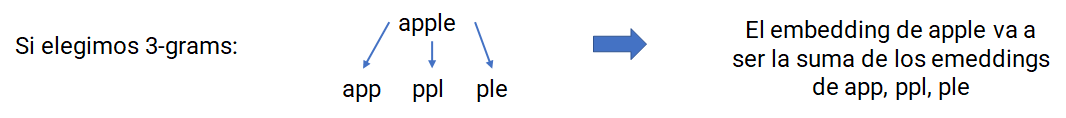

##### Gensim

Para FastText también hay diversos modelos disponibles, compartidos por [Facebook](https://fasttext.cc/docs/en/english-vectors.html).

In [ ]:
pip install --upgrade gensim # en caso de que sea necesario podemos actualizar la versión de Gensim

In [ ]:
import os
from zipfile import ZipFile

url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
datapath = "data/FastText/wiki-news-300d-1M.vec.zip"

os.makedirs("data/FastText", exist_ok=True)
descargar_archivo(url,datapath)


In [ ]:
print("Extracting data...")
with ZipFile(datapath, 'r') as zipObj:
 # Extract all the contents of zip file in different directory
 zipObj.extractall('data/FastText')

In [ ]:
from gensim.models import KeyedVectors

wv = KeyedVectors.load_word2vec_format('data/FastText/wiki-news-300d-1M.vec')

In [ ]:
vector = wv['deploy']
print(vector.shape)
print(vector)

In [ ]:
print(wv.most_similar('banana'))

print(analogy(wv,'australia', 'beer', 'spain'))
print(analogy(wv,'australia', 'beer', 'france'))
print(analogy(wv,'man', 'king', 'women'))

Ahora, vamos a entrenar nuestros propios modelos de forma similar a como hicimos con la representación Word2Vec. Los parámetros que acepta este modelo son los mismos que para Word2Vec.

Primero, con el corpus grande.

In [ ]:
from gensim.models.fasttext import FastText

# estamos usando la misma configuración de parámetros que para Word2Vec, se pueden probar otros valores
feature_size = 10 
window_context = 30 
min_word_count = 1 
sample = 1e-3
sg = 0 # podemos cambiar este valor y ver cómo cambian los embeddings

ft_model = FastText(tokenized_hp, size=feature_size, window=window_context, min_count=min_word_count,sample=sample, iter=50)

Ahora vamos a buscar las más semejantes y graficarlas.

In [ ]:
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)] for search_term in ['harry','hermione','owl','school']}
print(similar_words)

words = sum([[k] + v for k, v in similar_words.items()], []) # solo sobre las palabras que especificamos y las relacioandas
wvs = ft_model.wv[words]
print_embeddings(words,wvs)

Ahora podemos hacer lo mismo con el corpus pequeño.

In [ ]:
# estamos usando la misma configuración de parámetros que para Word2Vec, se pueden probar otros valores
feature_size = 10 
window_context = 10 
min_word_count = 1 
sample = 1e-3
sg = 0 # podemos cambiar este valor y ver cómo cambian los embeddings

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in processed_corpus]

ft_model_corpus = FastText(tokenized_corpus, size=feature_size, window=window_context, min_count=min_word_count,sample=sample, iter=50)

Qué pasa si tratamos de obtener la representación de una palabra que no existe en el diccionario?

In [ ]:
vector = wv['deployar'] # wv.get_vector('deployar') otra opción
print(vector.shape)
print(vector)

In [ ]:
del wv

Contrario a lo que hubíeramos esperado considerando como ``FastText`` construye las representaciones, da error.

In [ ]:
# puede que se necesite instalar esto
pip install pybind11 

In [ ]:
pip install fasttext

In [ ]:
url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz'
datapath = 'data/FastText/cc.en.300.bin'

descargar_archivo(url,datapath+'.gz')

In [ ]:
import gzip
import shutil

with gzip.open(datapath+".gz","rb") as f_in:
  with open(datapath,"wb") as f_o:
    shutil.copyfileobj(f_in,f_o)

In [ ]:
import fasttext
model = fasttext.load_model('data/FastText/cc.en.300.bin')

In [ ]:
print('deployar' in model)

model['deployar']
# model.get_word_vector('deployar') # de cualquiera de las dos formas

In [ ]:
model.get_nearest_neighbors('deployar', k=10) # probar con palabras que sí estén en el diccionario

In [ ]:
del model

### ELMo: Embeddings from Language Models

Objetivos:
* Modelar las características del uso de las palabras (sintaxis y semántica).
* Modelar como los usos varían de acuerdo a los contextos.

En lugar de utilizar un embedding fijo para cada palabra, ELMo analiza la oración completa antes de asignar cada palabra a un embedding específico.
* Se basa en una LSTM bi-direccional y extrae el hidden state de cada layer para secuencia de entrada de palabras.
Calcula la weighted sum de esos estados para obtener el embedding de cada palabra.
* Los pesos para cada hidden state son dependientes de la tarea y aprendidos.
Aprende a predecir cuál será la siguiente palabra en la secuencia .
* Fácil de integrar con otros modelos.


*Nota.* Acá vamos a trabajar con el modelo por defecto, pero hay más [modelos disponibles](https://allennlp.org/elmo), inclusive en otros idiomas.

Como en los casos anteriores, puede tardar.


In [ ]:
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0"
!pip3 install tensorflow_text==1.15
!pip3 install chart_studio

*Nota*. Reiniciar el runtime.

In [ ]:
# si hay algún problema con la ejecución, cambiar el runtime a gpu
import tensorflow as tf
import tensorflow_hub as hub

elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

Hay dos formas de obtener los embeddings, definiendo los ``signatures``:
* ``default``. Toma una oración sin tokenizar como entrada (una lista de String). Luego, el módulo se encargará de tokenizarlas haciendo un split por espacios.
* ``tokens``. Toma una oración tokenizada (una lista de lista de tokens). Además, hay que darle: la longitud de cada oración en cantidad de tokens, o la entrada con padding (completando las oraciones con tokens vacíos hasta el máximo de las longitudes).

La salida es un diccionario que contiene:

* ``word_emb``. La representación de las palabras.
* ``lstm_outputs1``. La primera capa oculta de la LSTM.
* ``lstm_outpus2``. La segunda cada oculta de la LSTM.
* ``elmo``. La suma ponderada de las 3 capas con pesos entrenables.
* ``default``. La representación con fixed mean-pooling de las representaciones.

Para luego poder graficar, vamos a utilizar la salida ``default``.

Acá vamos a recorrer las oraciones de nuestro corpus y obtener los vectores por cada una de ellas.

In [ ]:
sentences = processed_corpus # para poder cambiar fácil de corpus

x=[]
with tf.Session() as sess:
  for i in tqdm(range(0, len(sentences), 100)):

    embeddings = elmo( # generamos sobre qué vamos a obtener los embeddings
      sentences[i:min(i+100, len(sentences))],
      signature="default", # acá puede ser tokens también, es decir, una lista de listas
      as_dict=True)["default"] # obtenemos la salida que nos interesa
      
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    x.append(sess.run(embeddings)) # conseguimos los embeddings

In [ ]:
import numpy as np
x = np.concatenate(x, axis=0)

In [ ]:
print(x[1,:])

Ahora, vamos a graficar de forma parecida a lo que hicimos antes. Le vamos a agregar interactividad.

In [ ]:
from sklearn.decomposition import PCA # PCA lo vamos a ver más adelante y también en el último curso

pca = PCA(n_components=8) # la cantidad de componentes debe ser el mínimo entre el número de features y el de instancias, 8 es el número de instancias del corpus pequeño
y = pca.fit_transform(x)

from sklearn.manifold import TSNE

y = TSNE(n_components=2).fit_transform(y) # further reduce to 2 dim using t-SNE

In [ ]:
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

data = [
    go.Scatter(
        x=[i[0] for i in y],
        y=[i[1] for i in y],
        mode='markers',
        text=[i for i in sentences],
    marker=dict(
        size=16,
        color = [len(i) for i in sentences], #set color equal to a variable
        opacity= 0.8,
        colorscale='Viridis',
        showscale=False
    )
    )
]
layout = go.Layout()
layout = dict(
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )
fig = go.Figure(data=data, layout=layout)
file = plot(fig, filename='Sentence encode.html')

from google.colab import files
files.download('Sentence encode.html')

## Representando documentos: Cómo capturar las relaciones de las palabras de un texto en un único vector?

Hasta acá tenemos las representaciones de cada palabra individual, las cuales
* Ignorar el orden de las palabras en una oración.
* Ignoran la semántica de la oración en su conjunto.

Pero qué sucede si quisiéramos encontrar la representación completa de un documento porque queremos realizar alguna clasificación? 


#### Promediando word2vec

Una estrategia simple es la de promediar los vectores obtenidos para cada una de las palabras en el texto, como hacemos a continuación. 

Sin embargo, no hace falta hacerlo manualmente, dado que algunas bibliotecas traen implementadas algunas opciones.

In [ ]:
import pandas as pd

def average_word_vectors(words, model, vocabulary, num_features):
  feature_vector = np.zeros((num_features,),dtype="float64")
  nwords = 0.
  for word in words:
    if word in vocabulary:
      nwords = nwords + 1.
      feature_vector = np.add(feature_vector, model[word])
  if nwords:
    feature_vector = np.divide(feature_vector, nwords)
  return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
  vocabulary = set(model.wv.index2word)
  features = [average_word_vectors(tokenized_sentence, model, vocabulary,num_features) for tokenized_sentence in corpus]
  return np.array(features)

In [ ]:
# obtenemos los embeddings de los documentos
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_hp, model = w2v_model_hp, num_features=feature_size)
pd.DataFrame(w2v_feature_array,index=processed_hp)

### Doc2Vec

El objetivo es crear una representación de un documento independientemente de su longitud.

Es una extensión de word2vec CBOW al que le agregaron otro vector, el cual es único para cada document.

Luego, cuando se entrenan los vectores de palabras, también se entrena el vector de documentos, el cual al final tiene una representación numérica del documento.


En este modelo, la concatenación o promedio del vector con el contexto (en este caso de 3 palabras), es utilizado para predecir la siguiente. 
El vector de documento representa la información faltante del contexto actual y puede funcionar como una memoria del contenido del documento

Mientras los vectores de palabra representan el concepto de una palabra, el vector de document intenta representar el concepto del documento.


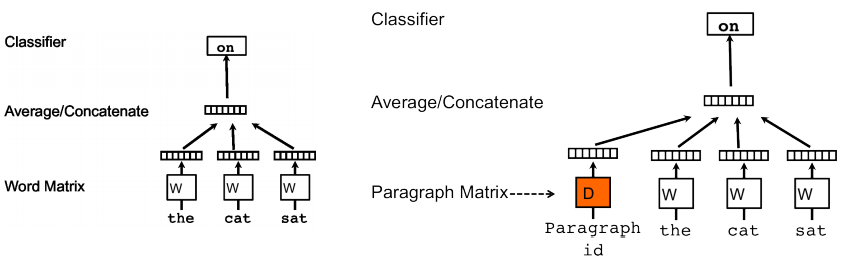

#### Gensim

Primero, vamos a probar un modelo pre-entrenado, en este caso basado en Associated Press News. 

Para otros modelos, ver en [Github](https://github.com/jhlau/doc2vec).

Lo vamos a estar descargndo de Drive, por el tamaño del archivo, vamos a usar ``gdown``.

In [ ]:
pip install gdown

In [ ]:
import gdown

url = "https://drive.google.com/uc?export=download&id=1heQbUbX48WUJpdqoWV-F-k1CvQCo70dM"
datapath = "data/doc2vec/apnews_dbow.tgz"

gdown.download(url, datapath, quiet=False)

In [ ]:
!tar xvzf ./data/doc2vec/apnews_dbow.tgz # otra forma de descomprimir los tgz

In [ ]:
import gensim.models 
datapath = "./apnews_dbow/doc2vec.bin"  

#load model
m_doc2vec = gensim.models.Doc2Vec.load(datapath)

In [ ]:
from nltk.tokenize import word_tokenize
import numpy as np

# requiere como entrada una lista de tokens
embd = m_doc2vec.infer_vector(word_tokenize("Harry is the best sorcerer".lower())) # obtenemos el embedding para una oración que no esté en el training
print(embd[0:10]) # imprimimos solo las 10 primeras dimensiones

Ahora, vamos a entrenar nuestro propio modelo de ``doc2vec``. 

Antes de poder entrenar el modelo, hay que transformar los documentos en la estructura que espera Gensim. Para ello, vamos a utilizar ``TaggedDocument`` que transforma cada documento en una lista de tokens asociada a un id de tipo entero.

Uno de los párametros del entrenamiento define qué training se utilizará:
* ``dm = 1``. "Distributed Memory" preserva el orden de las palabras.
* ``dm = 0``. "Distributed bag of words" se basa en una representación BOW que no preserva el orden de las palabras.

In [ ]:
# requiere como entrada una lista de tokens
embd = m_doc2vec.infer_vector(word_tokenize("Harry is the best sorcerer".lower())) # obtenemos el embedding para una oración que no esté en el training
print(embd)

In [ ]:
import numpy as np

# to find most similar doc using tags
similar_doc = m_doc2vec.wv.most_similar([embd]) # calcula la cosine similarity
similar_doc

Una vez entrenado el modelo, vamos a guardarlo para que quede listo para usarlo. 
Obviamente que los parámetros de entrenamiento pueden ser modificados.

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(hp)] # lo estamos entrenando con Harry Potter

max_epochs = 10
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, # ajuste para el training
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

In [ ]:
model.save("d2v.model")
print("Model Saved")

Vamos a cargar el modelo que acabamos de crear

In [ ]:
from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("d2v.model") 

Vamos a obtener los embeddings para las mismas oraciones que antes:

In [ ]:
# requiere como entrada una lista de tokens
embd = model.infer_vector(word_tokenize("Harry is the best sorcerer".lower())) # obtenemos el embedding para una oración que no esté en el training
print(embd)

In [ ]:
# to find most similar doc using tags
similar_doc = model.docvecs.most_similar([embd]) # calcula la cosine similarity
for sd in similar_doc:
    print(sd[0],processed_hp[int(sd[0])],sd[1])

#### spaCy

Esto es más sencillo dado que automáticamente provee las representaciones promedidadas para cada documento sin tener que implementar una función específica.

In [ ]:
import numpy as np
import spacy

nlp = spacy.load("en_core_web_lg")

In [ ]:
# acá no estamos obteniendo el vector correspondiente a cada palabra, sino que le estamos pidiendo el vector del documento
doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in processed_hp]) 

doc_glove_vectors

### Transformers



#### BERT: Bidirectional Encoder Representations from Transformers


A diferencia de los modelos direccionales en los que el texto es analizado de izquierda a derecha o de derecha a izquierda, BERT presenta un modelo bidireccional.
Estos modelos tienen un mayor entendimiento del contexto del lenguaje y su flujo que los modelos de una única dirección. 
Permite aprender el contexto de una palabra considerando todo lo que se encuentra a su alrededor.
Embeddings dependientes del contexto.

Se basa en el uso de Transformers.
Los transformers, en su forma más simple, incluyen dos partes: un encoder (que lee el texto de entrada) y un decoder que produce la predicción de la tarea.
Como el objetivo de BERT es generar un language model, solo el encoder es necesario.




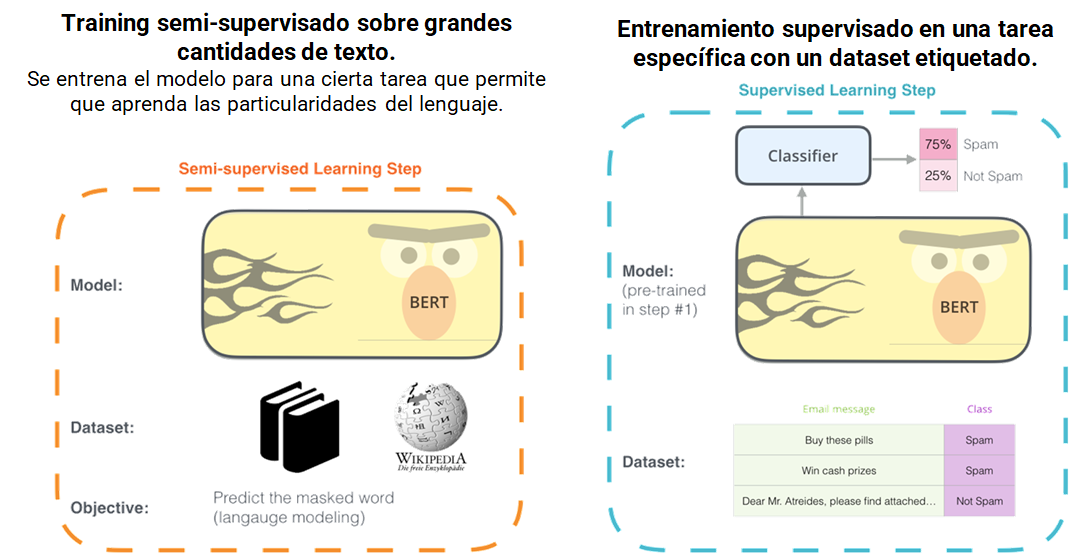

Vamos a utilizar la interfaz de [Hugging Face](https://huggingface.co/), que además de BERT incluye otros modelos como GPT y GPT-2.

Esta interfaz se basa en Pytorch y, en teoría, ofrece un buen balance entre APIS de alto nivel (se pueden utilizar sin necesidad de conocer exactamente cómo funcionan los modelos) y código en tensorflow.

In [ ]:
!pip install transformers

Vamos a trabajar con un modelo pre-entrenado por Google sobre Wikipedia y Book Corpus (un dataset que incluye más de 10_000 libros de diferentes géneros). Si bien es uno de los modelos más pequeños, se han reportado buenos resultados para diferentes benchmarks. 

Dado que el objetivo en esta notebook es solamente obtener las representaciones, es decir, no vamos a realizar ninguna tarea "extra", vamos a utilizar el modelo básico.

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# opcional en caso de querer observar logs más detallados en la salida
import logging
#logging.basicConfig(level=logging.INFO)

In [ ]:
# cargamos el modelo pre-entrenado
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # uncased se refiere a que ignora el case de las palabras

A diferencia de los otros modelos para los cuales bastaba que los datos se encontrasen en la forma de listas de Strings (oraciones) o listas de listas de Strings (tokens), BERT requiere que los datos de entrada sigan un formato pre-determinado utilizando algunos tokens especiales:

* ``[CLS]``. Marca el comienzo del texto. Especificamente es requerido para las tareas posteriores de clasificación, sin embargo, BERT lo requiere siempre.
* ``[SEP]``. Marca la finalización de una oración, o la separación entre dos oraciones.
* Tokens que conforman el vocabulario utilizado en BERT.
* Los ids para los tokens obtenidos con el tokenizador de BERT.
* Ids enmascarados para indicar qué elementos en la secuencia son tokens y cuales son elementos de padding.
* Ids de segmentos utilizados para distinguir entre las oraciones.
* Embeddings posicionales para mostrar las posiciones de los tokens en la secuencia.

``Transformers`` provee opciones de tokenización que resuelven todas estas cuestiones. 

In [ ]:
text = "I want embeddings."
marked_text = "[CLS] " + text + " [SEP]" # agregamos el token de inicio de texto y el de separador de oraciones

# Tokenizamos el texto
tokenized_text = tokenizer.tokenize(marked_text)

print (tokenized_text)

Como se puede observar, la palabra ``embeddings`` fue dividia en cuatro tokens diferentes correspondiente a sub-palabras o n-grams de caracteres. Los ``#`` indican que ese token está precedido por otros que forman parte de la misma palabra. Por ejemplo, el token ``##bed`` es distinto al token ``bed``. El primero indica que es una sub-palabra de otro, mientras que el segundo indica la palabra completa.
['em', '##bed', '##ding', '##s']

Esto se debe a que BERT fue creado siguiendo el modelo "WordPiece", el cual crea un vocabulario fijo de los caracteres individuales, sub-palabras y palabras que mejor fitean los datos. Dado que el límite del tokenizer de BERT es de 30_000, el modelo de WordPiece genera un vocabulario que contiene todos los caracteres del Inglés y aproximadamente las 30_000 palabras y sub-palabras más comunes en el corpus sobre el cual se realizó el entrenamiento. Entonces, el vocabulario contiene cuatro tipos de elementos:

* Palabras completas.
* Sub-palabras que aparecen al inicio de las palabras.
* Sub-palabras que no aparecen al inicio de las palabras (las precedidas por ``##``).
* Caracteres individuales.

Para tokenizar las palabras de acuerdo con este modelo, el tokenizador primero chequea si la palabra completa se encuentra en el vocabulario. Si no la encuentra, trata de romper la palabras en las sub-palabras más largas posibles que si se encuentren en el vocabulario. En última instancia, la palabra será descompuesta en los caracteres individuales. De esta forma, siempre se encontrará una representación para las palabras, y no es necesario recurrir a tokens ``UNKNOWN``. Asimismo, este tipo de representación hace que las sub-palabras mantengan algo del contexto de la palabra original, pudiendo luego combinar los embeddings de las sub-palabras para generar una aproximación de la palabra original.

Acá algunos tokens que pertenecen al vocabulario del modelo.

In [ ]:
list(tokenizer.vocab.keys())[5000:5020]

Ahora que ya tenemos el texto dividido en los tokens, el próximo paso es convertir las oraciones de una lista de Strings a una lista de índices dentro del vocabulario.

Para estos ejemplos, vamos autilizar una única oración que contiene la palabra ``project`` dos veces, con distinto significado.


In [ ]:
# Nuestro ejemplo a tratar para observar la contextualidad de los embeddings
text = "I like to project in my mind this awesome NLP project."

# agregamos los tokens especiales
marked_text = "[CLS] " + text + " [SEP]"

# dividimos la oración en tokens
tokenized_text = tokenizer.tokenize(marked_text)

# mapeamos los tokens a sus ids en el vocabulario
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# mostramos los tokens
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<8} {:>6,}'.format(tup[0], tup[1])) # {:<8} {:>6,} es simplemente para formatear más bonitas las columnas

BERT es originalmente entrenado con pares de oraciones, cuya distinción se hacía utilizando 0 y 1 para indicar a qué oración pertenece cada token. Entonces, lo que hay que hacer es por cada token en ``tokenized_text`` tenemos que indicar a qué oración pertenece: si a la oración 0 (se mapean a 0) o a la 1 (se mapean a 1). 

Si, quisieramos procesar dos oraciones, a toda la primera más el token ``[SEP]`` habría que asignarle 0 y al resto 1.


In [ ]:
# Todos los tokens pertenecen a la oración 1, les ponemos 1.
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

Antes mencionamos que ``Transformers`` permitía realizar todo el procesamiento de los tokens de forma automática. Para hacerlo, hay que utilizar:

In [ ]:
tokenizer.encode_plus(text)

Ya casi estamos listos para invocar al modelo BERT. Antes debemos convertir nuestras listas de Python a tensores de Torch (sin cambiarle las dimensiones).



In [ ]:
# convertimos a tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

Ahora si. La invocación a ``from_pretrained`` obtendrá el modelo especificado, en este caso ``bert-base-uncased``. Cuando termine, veremos impresa la definición del modelo, el cual tiene 12 capas.

Luego, ``model.eval()`` define que el modelo será solo utilizado para la obtención de embeddings y no para el entrenamiento, lo que hará que se deshaga de algunas "cositas" solo utilizadas durante el training.

In [ ]:
# cargamos el modelo
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, #  si queremos que el modelo nos muestre todos los estados ocultos
                                  )

# definimos que no queremos hacer entrenamiento
model.eval()

Vamos a obtener los embeddings para nuestro texto de ejemplo, obteniendo las salidas de las 12 capas.

In [ ]:
with torch.no_grad(): # define que no se contruya el grafo requerido para backpropagation dado que no lo vamos a utilizar. Ahorra consumo de memoria.

    outputs = model(tokens_tensor, segments_tensors)

    hidden_states = outputs[2] # qué tiene la salida depende de cómo lo hayamos configurado, en este caso, solo nos vamos a quedar con las salidas de los estados ocultos.

El objeto que recuperamos tiene 4 dimensiones con los siguientes elementos:

* El número de capas. El modelo tiene 12 capas, a las que hay que sumarle la entrada.
* El número de batch. Representa la cantidad de oraciones, en este caso, una.
* El número de tokens. 
* La cantidad de características/unidades ocultas.

Esto hace un total de 149_760 valores para representar una única oración.

In [ ]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Como se observa cuando obtuvimos los tamaños, los valores se encuentran agrupados por capa ``[# layers, # batches, # tokens, # features]``, sin embargo, como lo que queremos es la representación de los tokens, vamos a pasar a una representación agrupada por tokens: ``[# tokens, # layers, # features]``.

Para esto, vamos a recurrir a PyTorch.



In [ ]:
# Concatenamos los tensores de todas las layers. Stack nos crea una nueva dimensión
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

La dimensión de tamaño 1 es la de batches, que en este caso no nos interesa. La borramos.

In [ ]:
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

Finally, we can switch around the "layers" and "tokens" dimensions with permute.

In [ ]:
# Ahora si podemos intercambiar las dimensiones
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

Acá recuperamos los estados ocultos y tenemos que decidir cómo armamos nuestra representación final combinándolos de alguna forma. Recordemos que tenemos 13 vectores de longitud 768 por cada uno de nuestros tokens.

No hay una única respuesta. Vamos a probar algunas alternativas.


**Opción 1**

Concatenamos los 4 últimas capas, para obtener un único vector por token. Esto nos deja en que cada vector tendrá tamaño 3_072 (768 x 4).


In [ ]:
token_vecs_cat = [] # para almacenar los vectores

for token in token_embeddings: # por cada token
    
    # append de los vectores
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0) # los negativos son para acceder de atrás para adelante
    
    # agregamos la representación
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

**Opción 2**

Sumar los resultados de las capas.

In [ ]:
token_vecs_sum = []

for token in token_embeddings:

    sum_vec = torch.sum(token[-4:], dim=0)
    
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Ya tenemos nuestras representaciones! Ahora nos queda verificar que efectivamente sean contextualizadas. Recordemos que en la oración de ejemplo incluímos la palabra ``project`` con dos significados diferentes, para los cuales, las representaciones deberían ser distintas.

Para acceder a las representaciones, necesitamos los números de los tokens que nos interesan:

In [ ]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

El 4 y el 12. Vamos a imprimir una parte:

In [ ]:
print("project v", str(token_vecs_sum[4][:5]))
print("project n", str(token_vecs_sum[12][:5]))

Como esperábamos, son distintos! La contextualización está.

Esta no es la única alternativa que provee BERT. Por ejemplo, también está [bert-as-service](https://github.com/hanxiao/bert-as-service) la cual "esconde" varios de los aspectos que estuvimos trabajando y permiten "fácilmente" obtener las salidas deseadas. En este caso, en lugar de combinar los resultados de las últimas 4 capas, se queda con las dos últimas. Funciona teniendo que ejecutar un cliente y un servidor, pudiendo el servidor incluso estar corriendo en otro lado.

#### InferSent

Modelo supervisado que provee una representación semántica de oraciones en inglés.

El entrenamiento está basado en tareas de  inferencia (NLI).
Particularmente, en pares de oraciones etiquetadas como: entailment, contradiccion, neutral.

Probaron diferentes arquitecturas. La que mejores resultados dio:
Se basa en una LSTM bi-direccional que calcula los n vectores para las n palabras y cada vector es la concatenación de la salida de un LSTM forward y una LSTM backward que lee la oración en la dirección opuesta.
Luego, max pooling es aplicada a los vectores concatenados para formar la representación final.

Útil para:
Clasificación binaria y multi-clase.
Semejanza semántica.
Detección de parafraseo.
Tareas de imágenes y captions.


In [ ]:
!wget https://github.com/facebookresearch/InferSent/archive/master.zip
!unzip master.zip

InterSent no está distribuída como una biblioteca, sino que es un archivo Python que debe convivir en el mismo espacio que nuestra notebook. Para eso, vamos a copiarlo a nuestro directorio raiz.

In [ ]:
!cp ./InferSent-master/models.py ./models.py

Para poder utilizarla, tenemos que traernos los modelos. Con uno solo de ellos alcanza.

*Nota*. El de ``GloVe`` pesa aproximadamente 2GB, mientas que el de ``fastText`` menos de 1.5GB.

In [ ]:
!mkdir GloVe
!curl -Lo GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip GloVe/glove.840B.300d.zip -d GloVe/ # otra forma de descomprimir

In [ ]:
!mkdir fastText # otra forma de crear directorios
!curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip fastText/crawl-300d-2M.vec.zip -d fastText/

Y también los encoders propiamente dichos. 
Un encoder para cada modelo:
* ``infersent1.pkl`` para GloVe.
* ``infersent2.pkl`` para FastText

In [ ]:
!mkdir encoder

In [ ]:
!curl -Lo encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl


In [ ]:
!curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

Ahora si, podemos importarla y usarla.

In [ ]:
from models import InferSent
import torch

model_version = 2 # modificar de acuerdo al modelo elegido
MODEL_PATH = "encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

In [ ]:
W2V_PATH = 'GloVe/glove.840B.300d.txt' if model_version == 1 else 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

Ahora, podemos obtener los embeddings para nuestras oraciones.
Tenemos dos opciones para definir el vocaulario:

1. ``infersent.build_vocab(sentences, tokenize=True)`` obtener el vocabulario a partir de nuestras oraciones. Si ``tokenize=True`` se va a requerir tener ``punkt`` de nltk.

2. ``infersent.build_vocab_k_words(K=100000)`` directamente importar las ``k`` palabras más frecuentes del modelo.

In [ ]:
sentences = hp[0:1] # las 10 primeras oraciones de hp
print(len(sentences))
print(sentences)

Ejecutar solo una de las siguientes opciones.

In [ ]:
import nltk
nltk.download('punkt')

model.build_vocab(sentences, tokenize=True)

In [ ]:
model.build_vocab_k_words(K=100000)

Obtenemos la representación. Cada vector tendrá tamaño 4096.

In [ ]:
embeddings = model.encode(['Harry Potter and the Sorcerer\'s Stone CHAPTER ONE THE BOY WHO LIVED Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much.'], bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))

embeddings2 = model.encode(['harry potter sorcerers stone chapter one boy lived mr mrs dursley number four privet drive proud say perfectly normal thank much'], bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))

for x in zip(embeddings[0],embeddings2[0]):
  print(x[0]-x[1])

También podemos visualizar cuál es la importancia de cada palabra en la oración.

In [ ]:
model.visualize(sentences[0], tokenize=True)